In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram as plot_dendrogram, linkage
import os

In [2]:
data_v0 = pd.read_csv('clusters-5-v0.csv')
data_v1 = pd.read_csv('clusters-5-v1.csv')
data_v2 = pd.read_csv('clusters-5-v2.csv')

if not os.path.exists('Images'):
    os.makedirs('Images')

if not os.path.exists('Metrics'):
    os.makedirs('Metrics')

dataset = {
    'Clusters-5-v0': pd.read_csv('clusters-5-v0.csv'),
    'Clusters-5-v1': pd.read_csv('clusters-5-v1.csv'),
    'Clusters-5-v2': pd.read_csv('clusters-5-v2.csv')
}

scalers = {name: StandardScaler().fit_transform(data[['x1', 'x2']]) for name, data in dataset.items()}

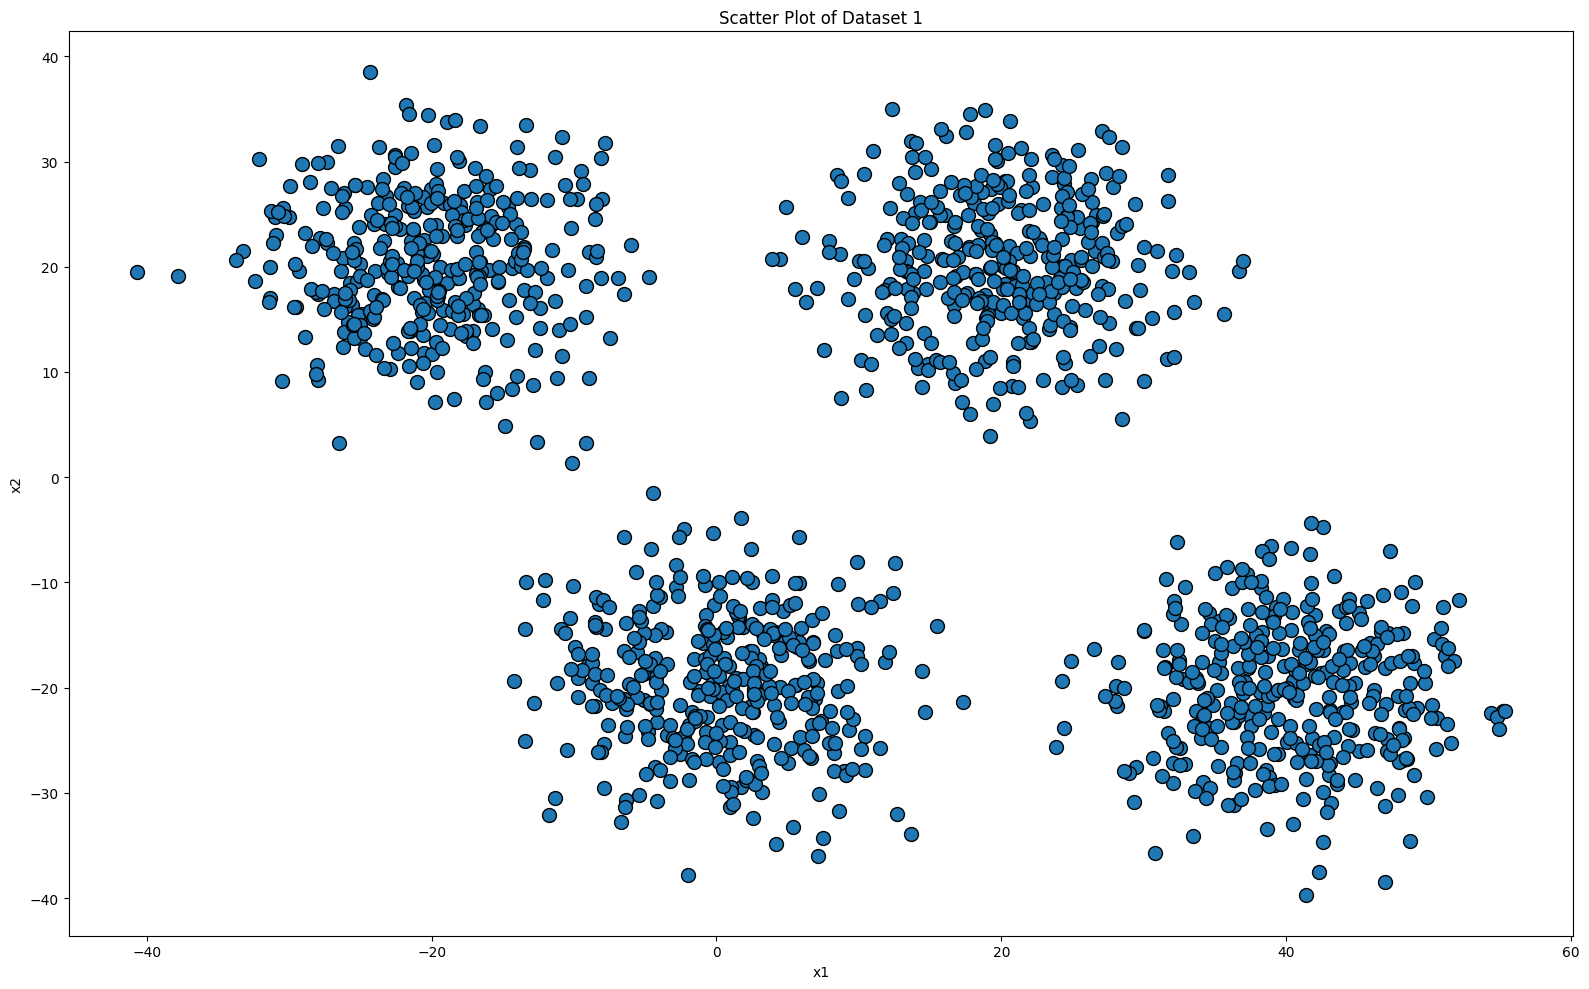

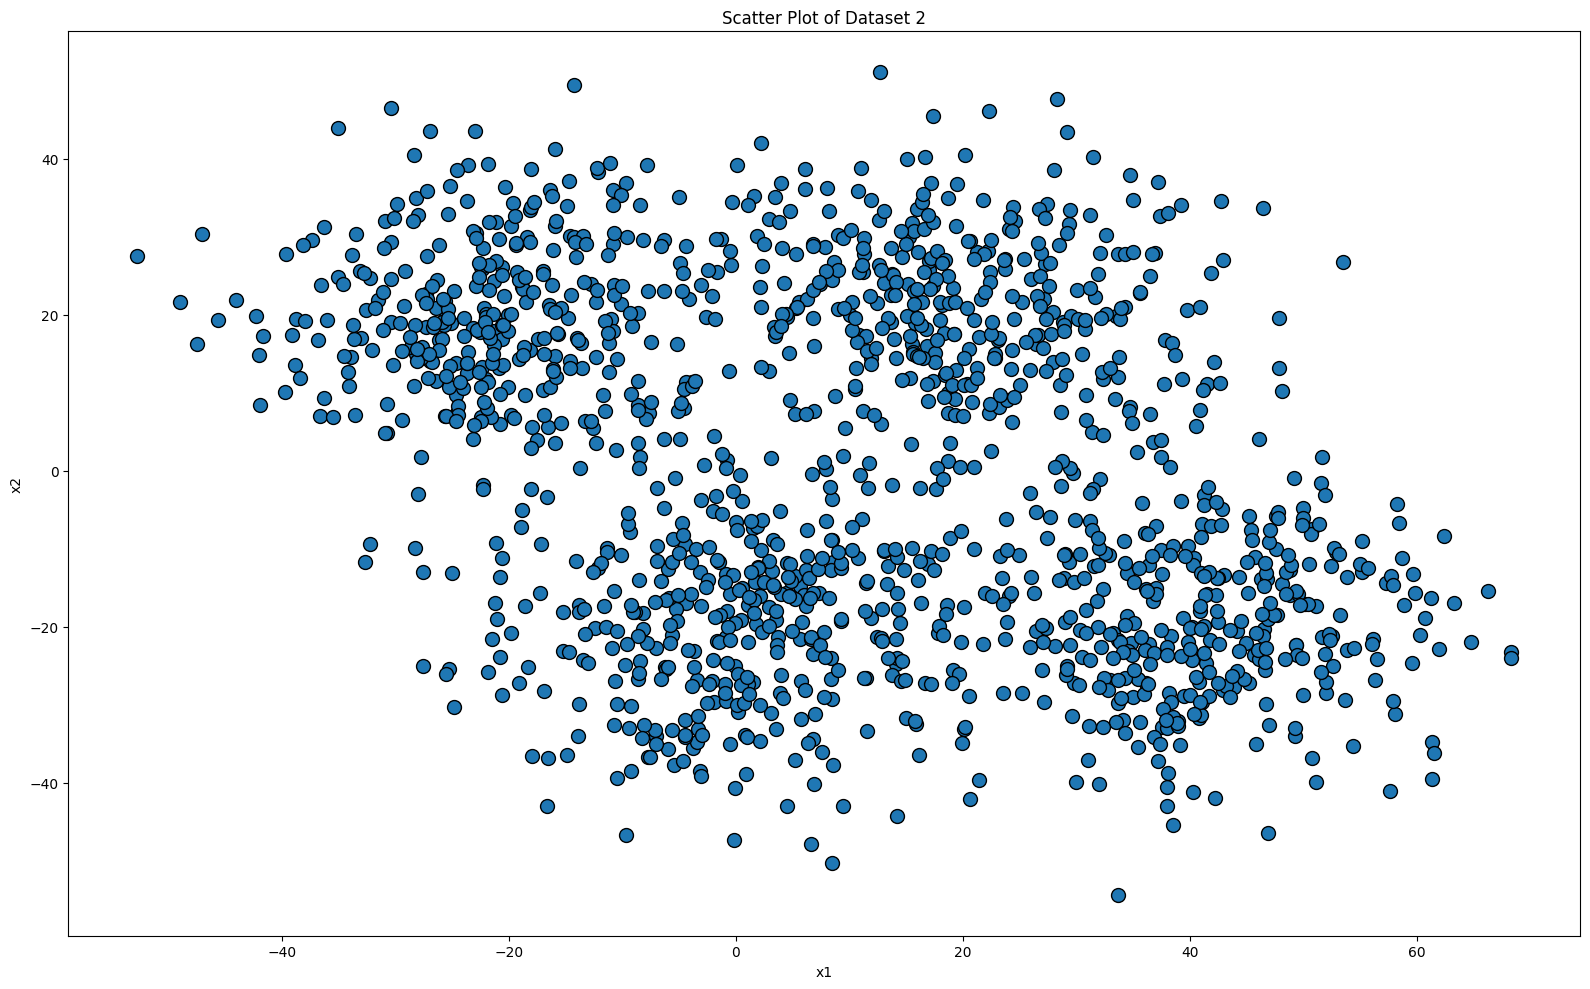

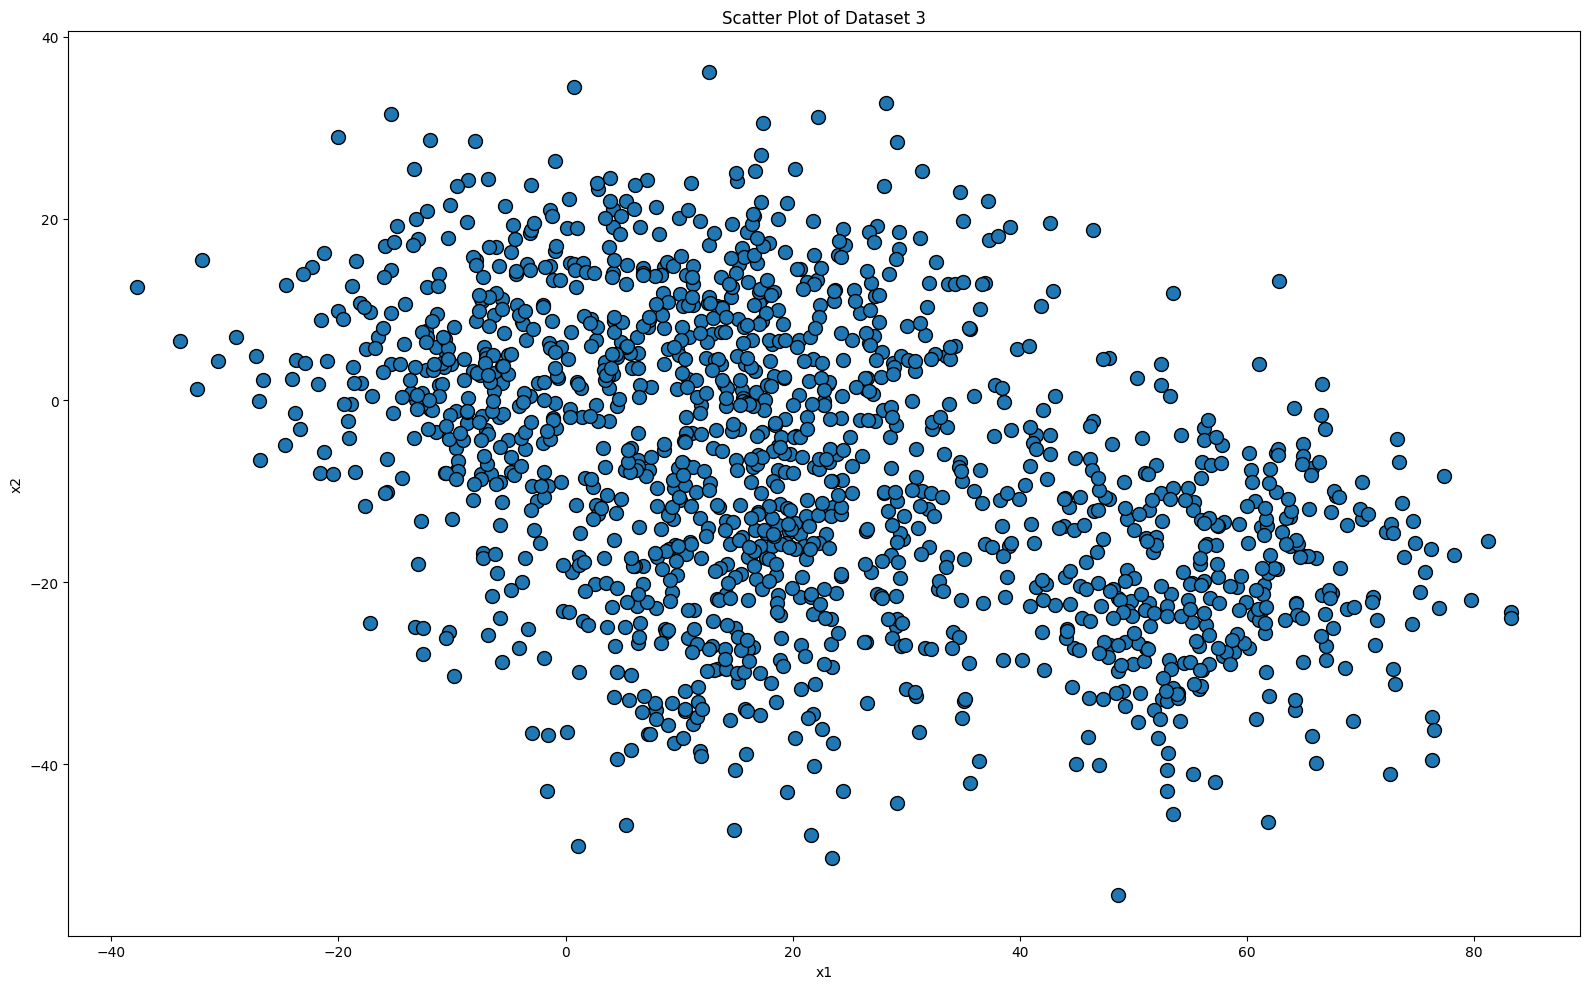

In [3]:
datasets = [(data_v0, "Dataset 1"), (data_v1, "Dataset 2"), (data_v2, "Dataset 3")]

# Iterate over each dataset for visualization and analysis
for i, (data, label) in enumerate(datasets):
    # Scatter Plot
    plt.figure(figsize=(16, 10))
    
    # plt.subplot(1, 2, 1)
    plt.scatter(data['x1'], data['x2'], s=100, edgecolors='black')
    plt.title(f'Scatter Plot of {label}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.savefig(f'Images/dataset-{i+1}-overview.png', dpi=400)
    plt.show()

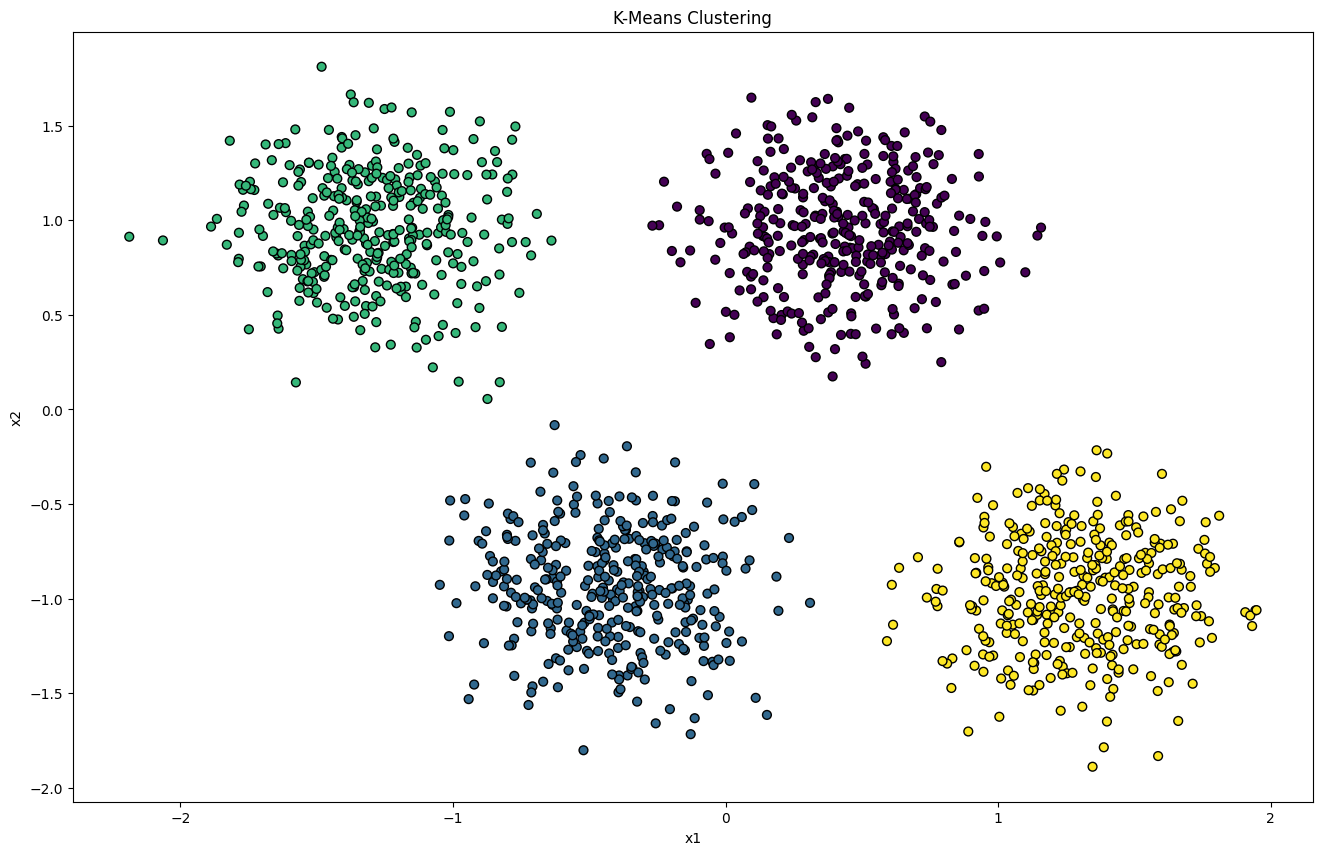

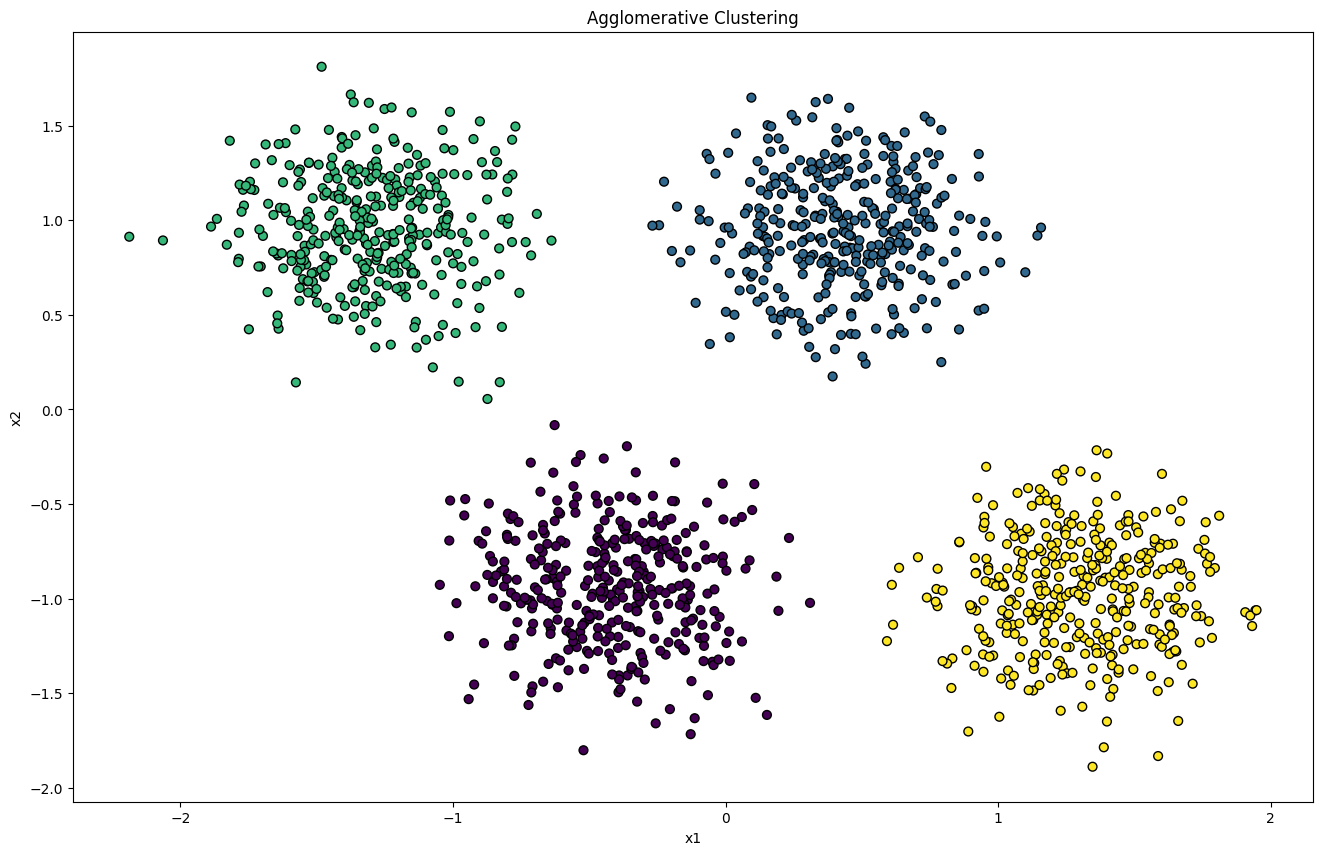

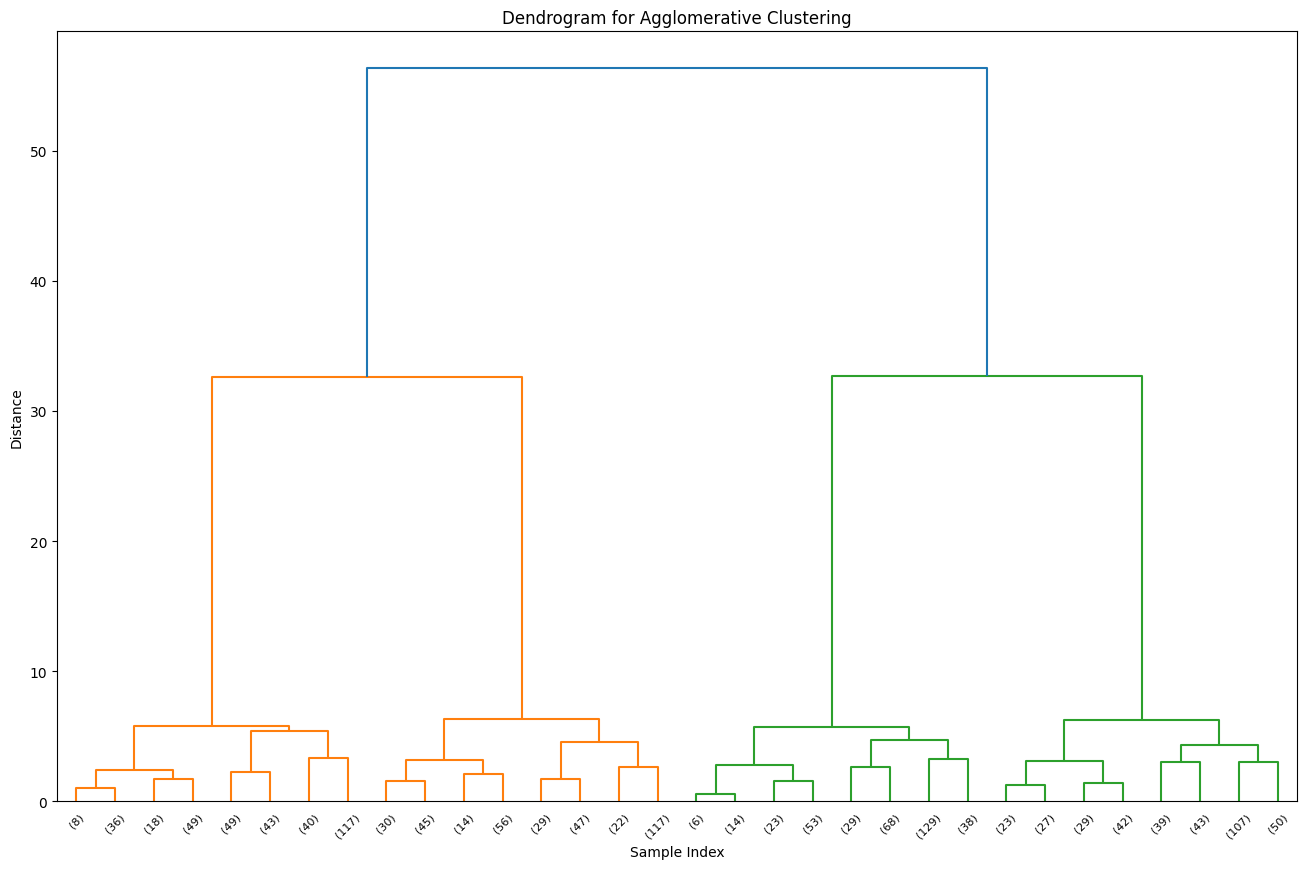

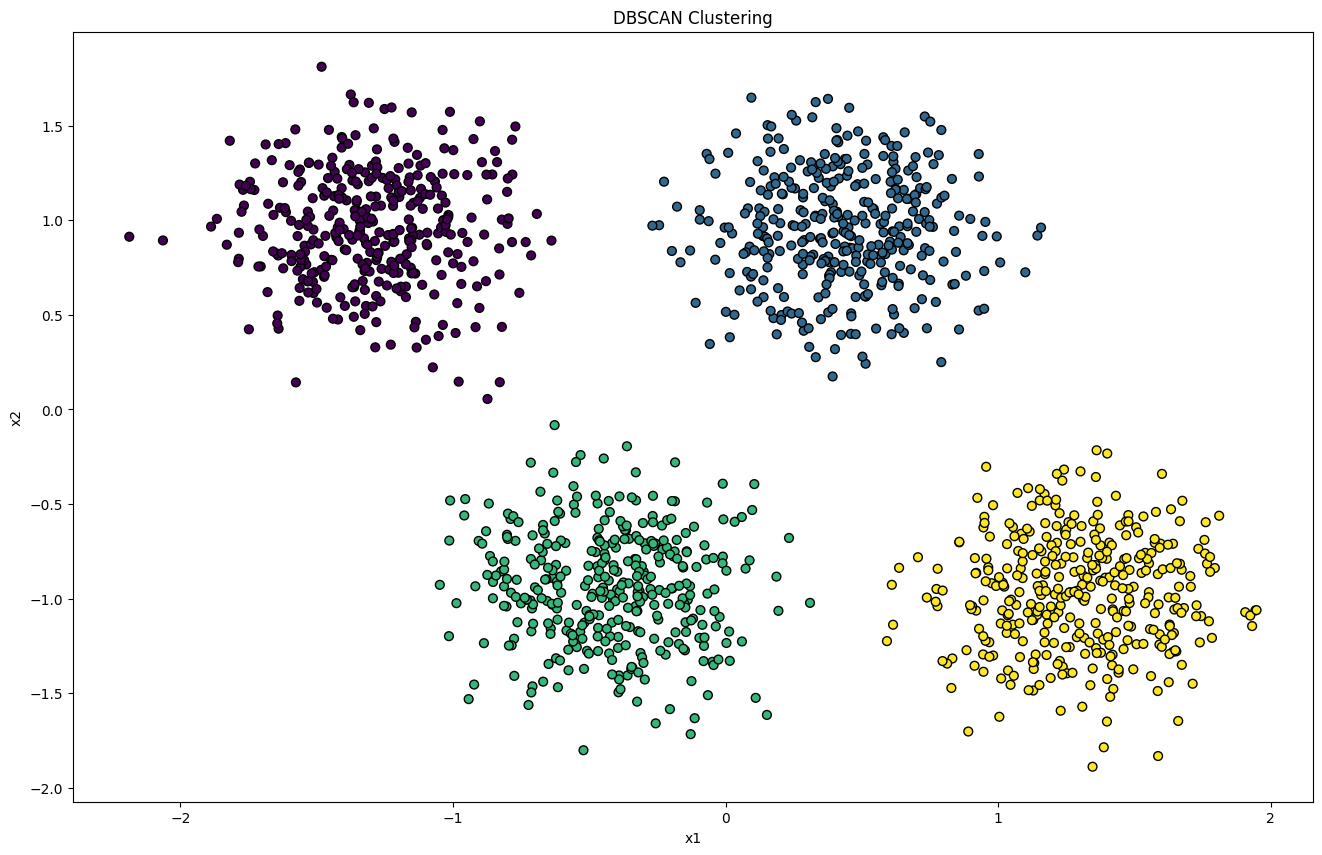

Best DBSCAN parameters: eps=0.3107537688442211, min_samples=9


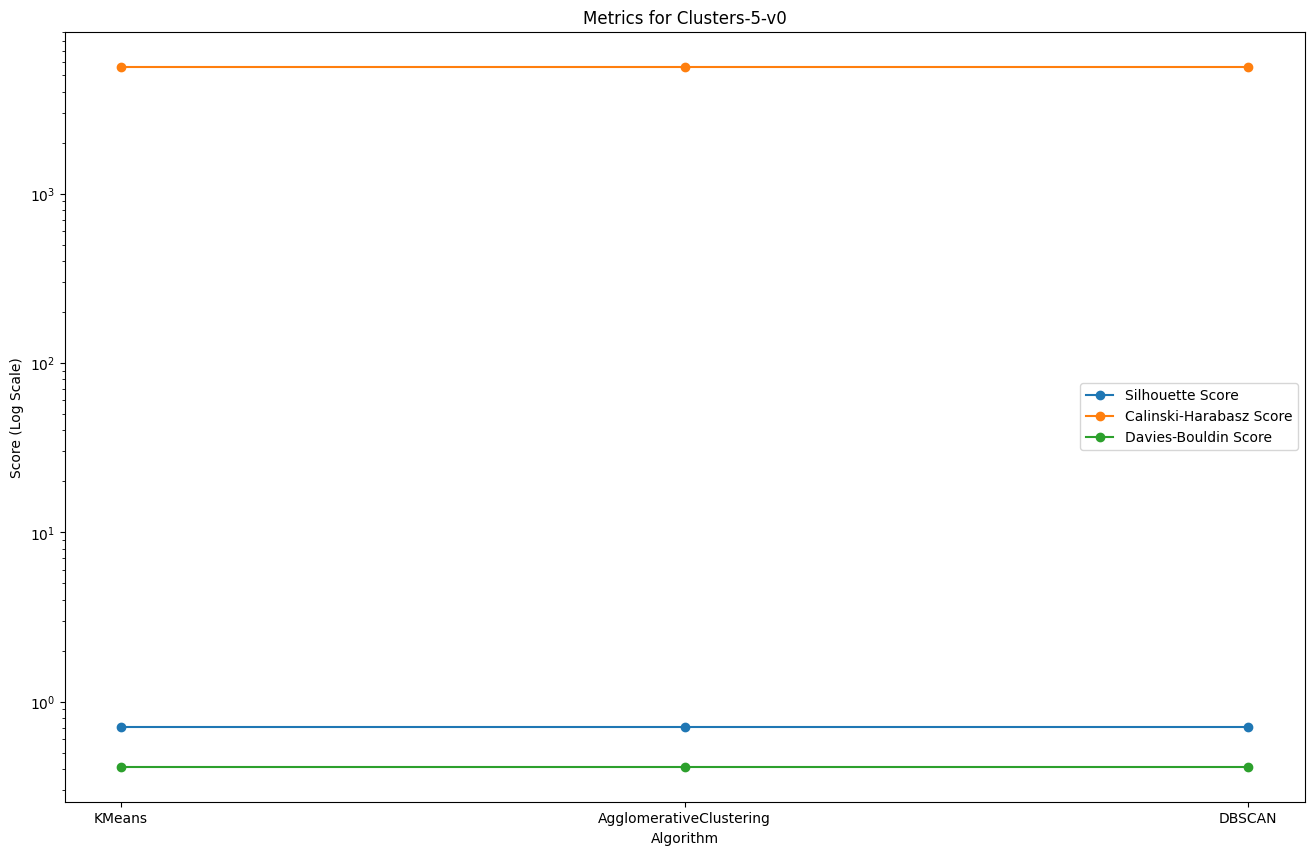

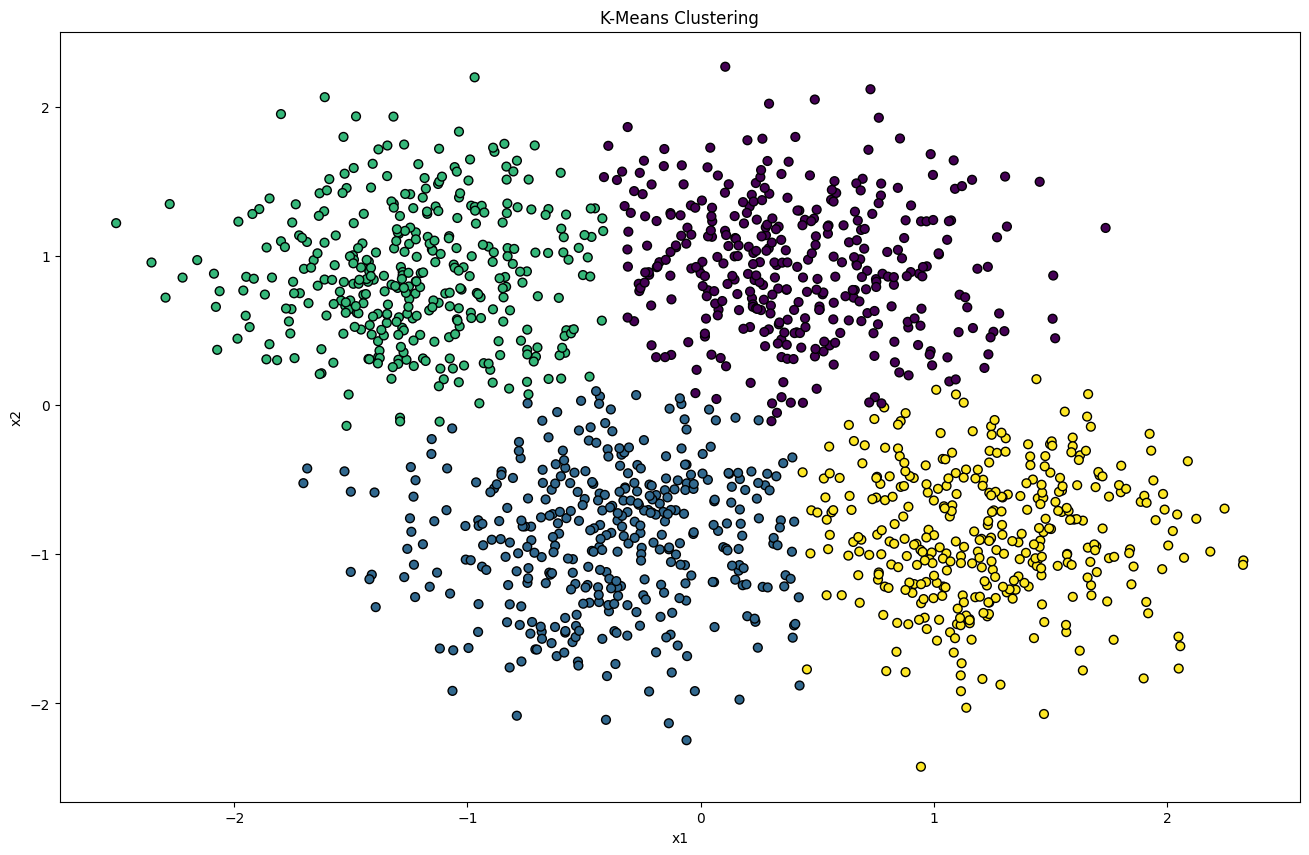

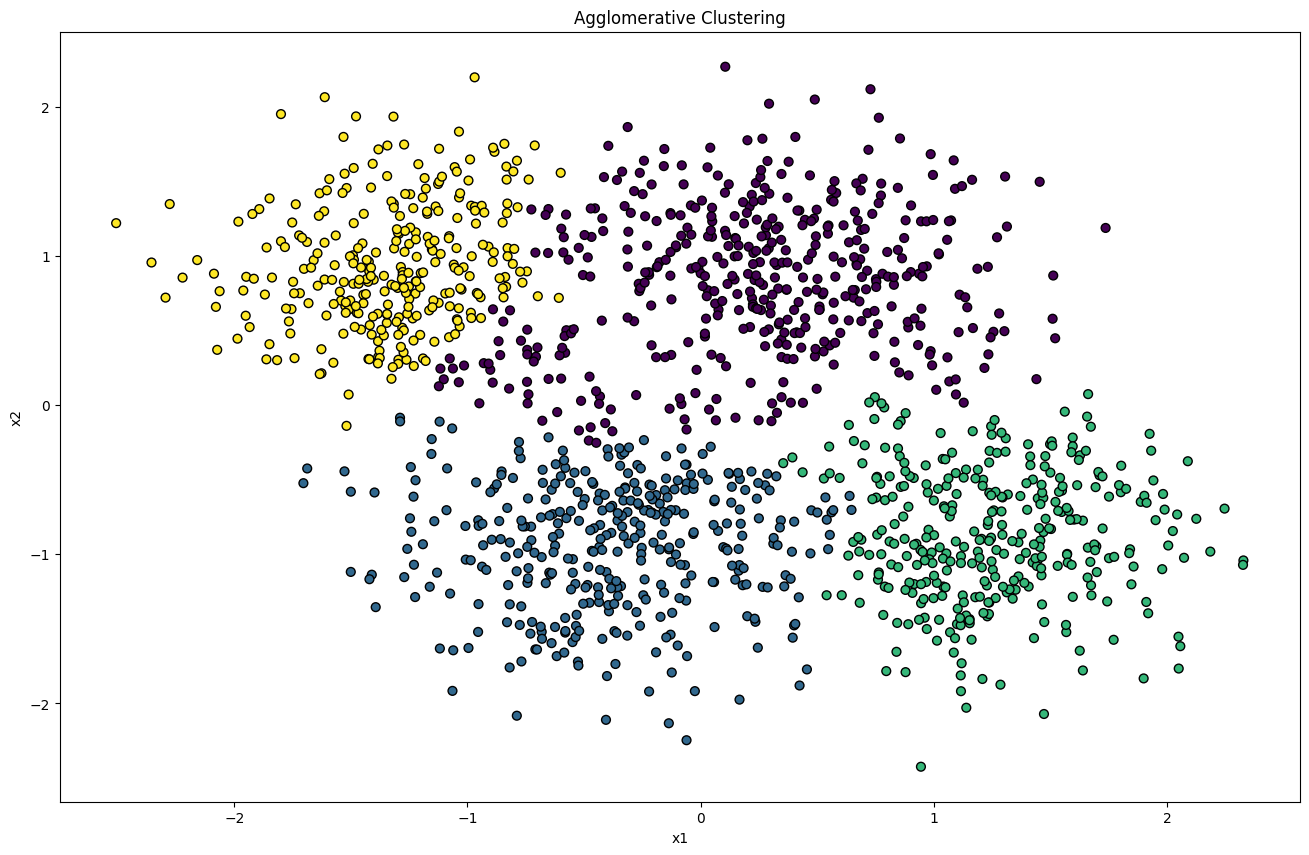

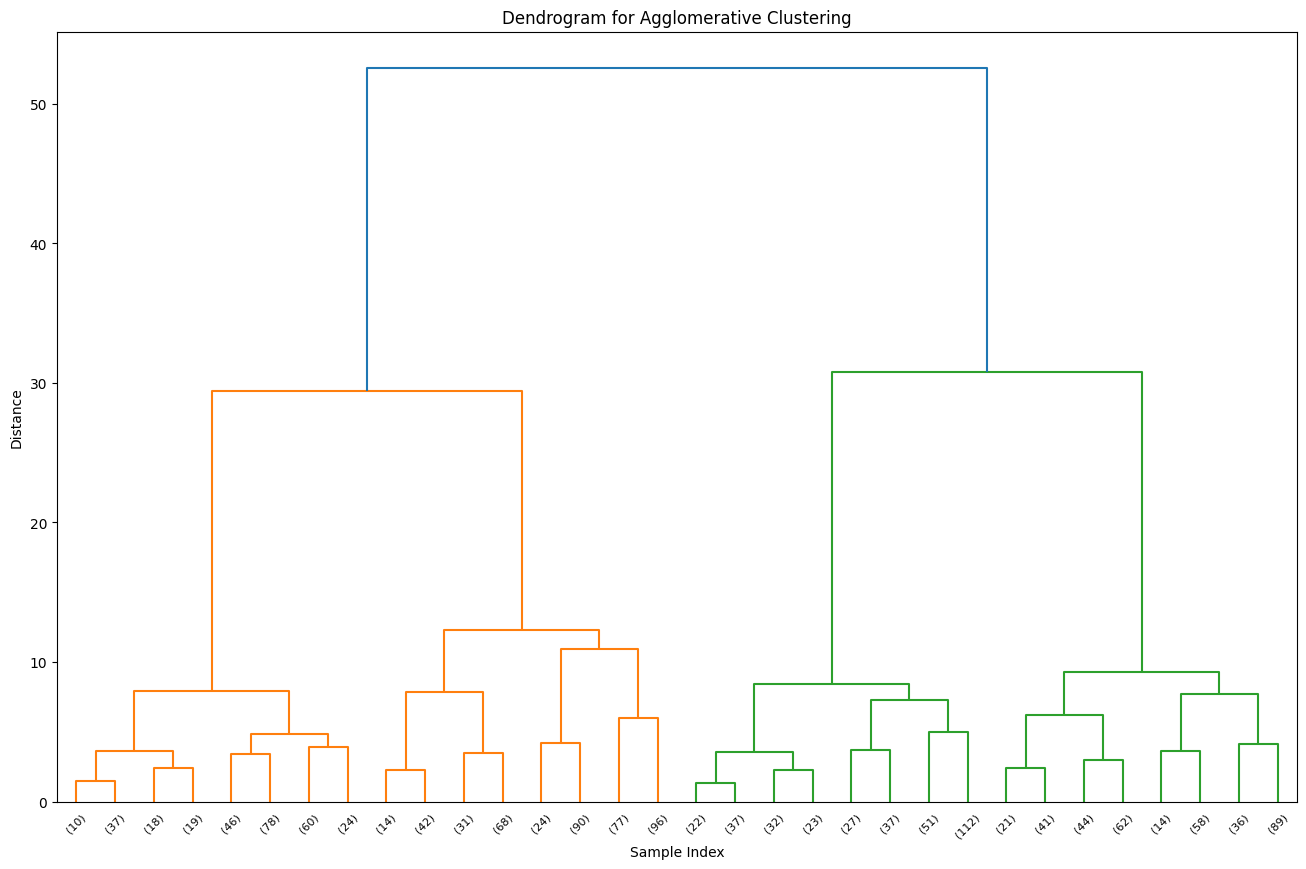

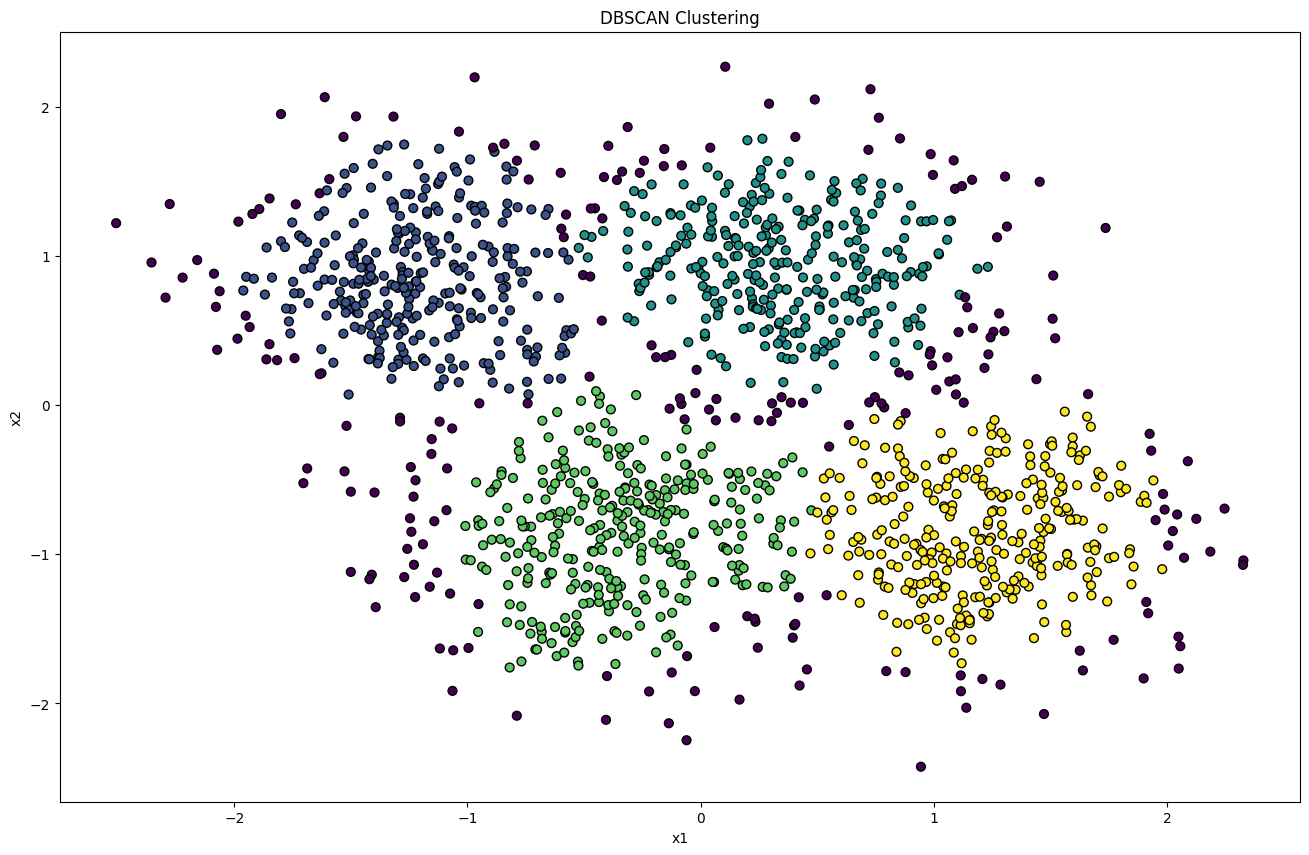

Best DBSCAN parameters: eps=0.23055276381909548, min_samples=20


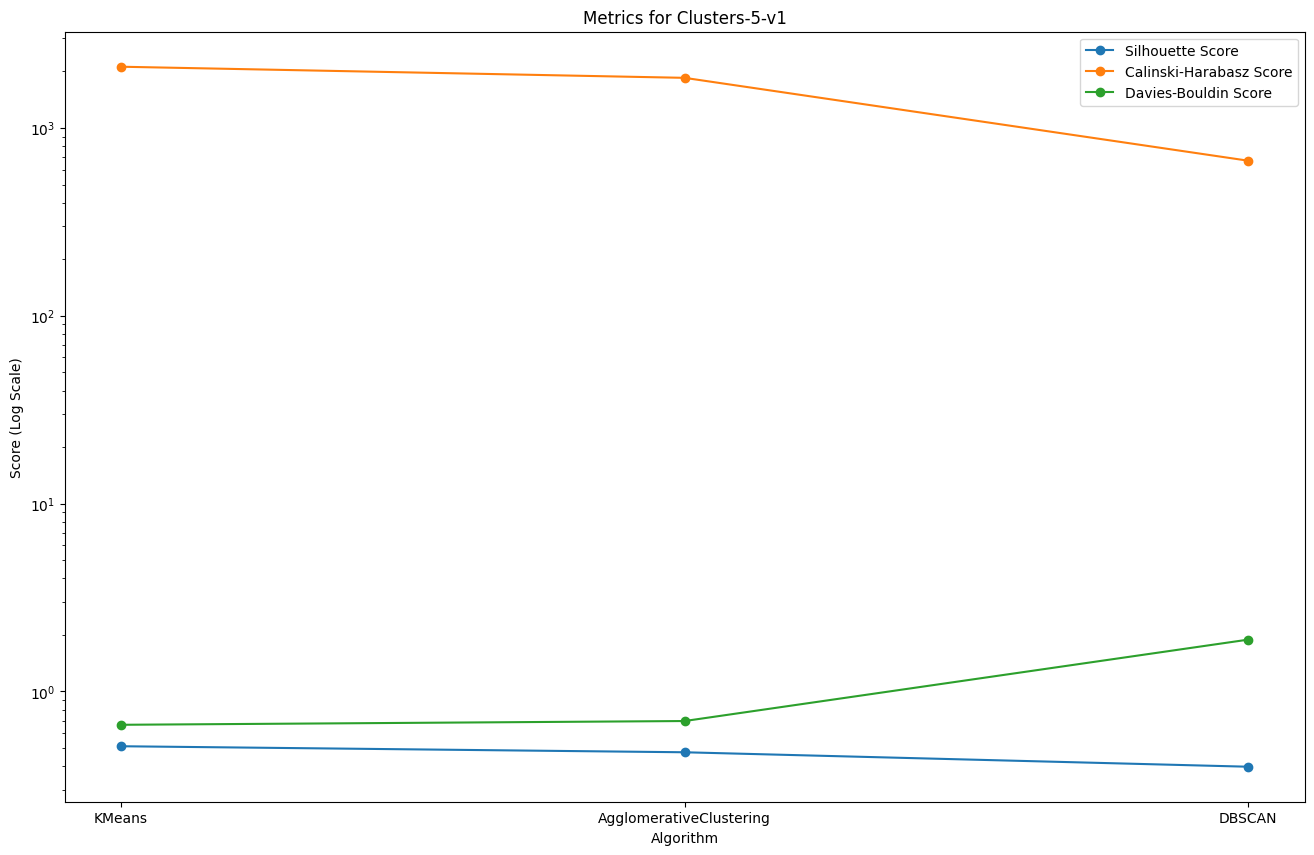

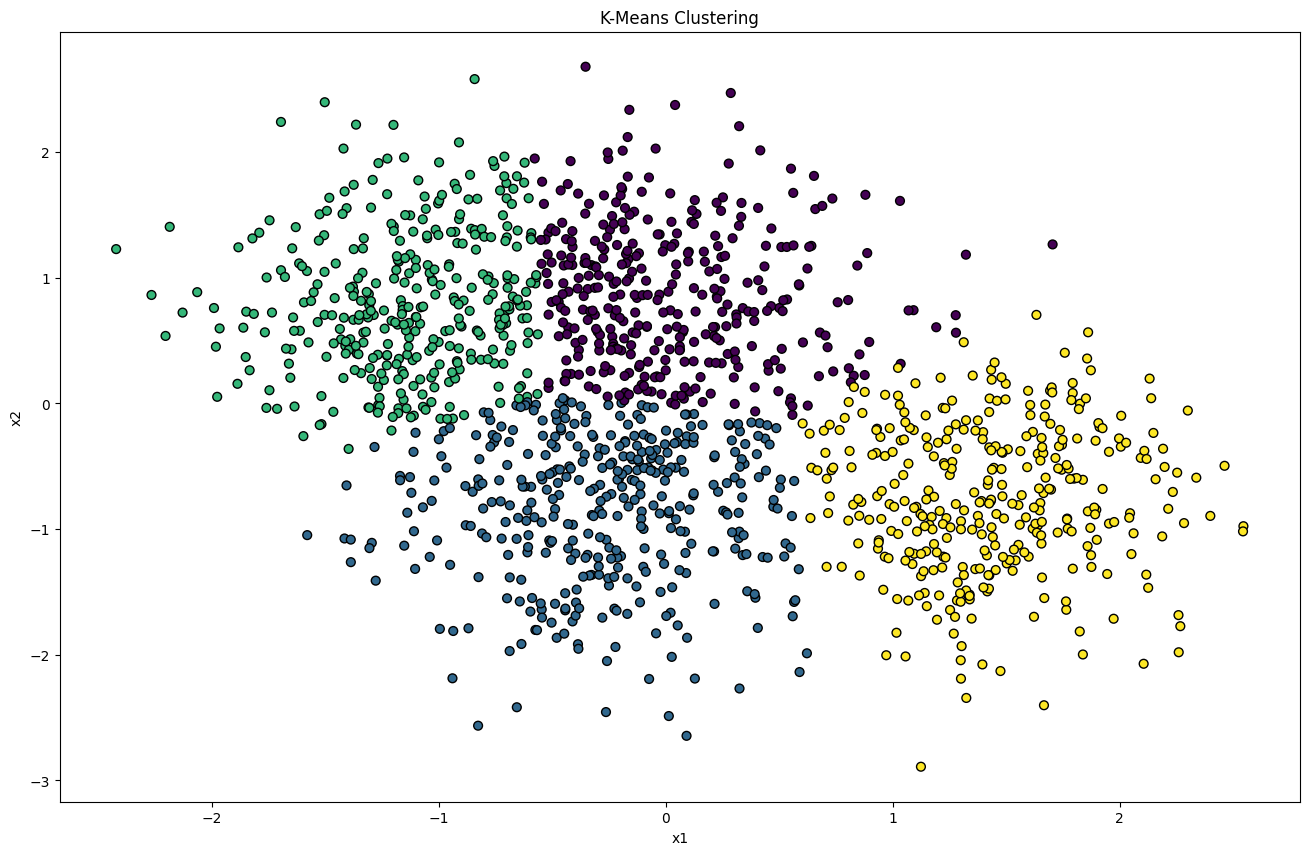

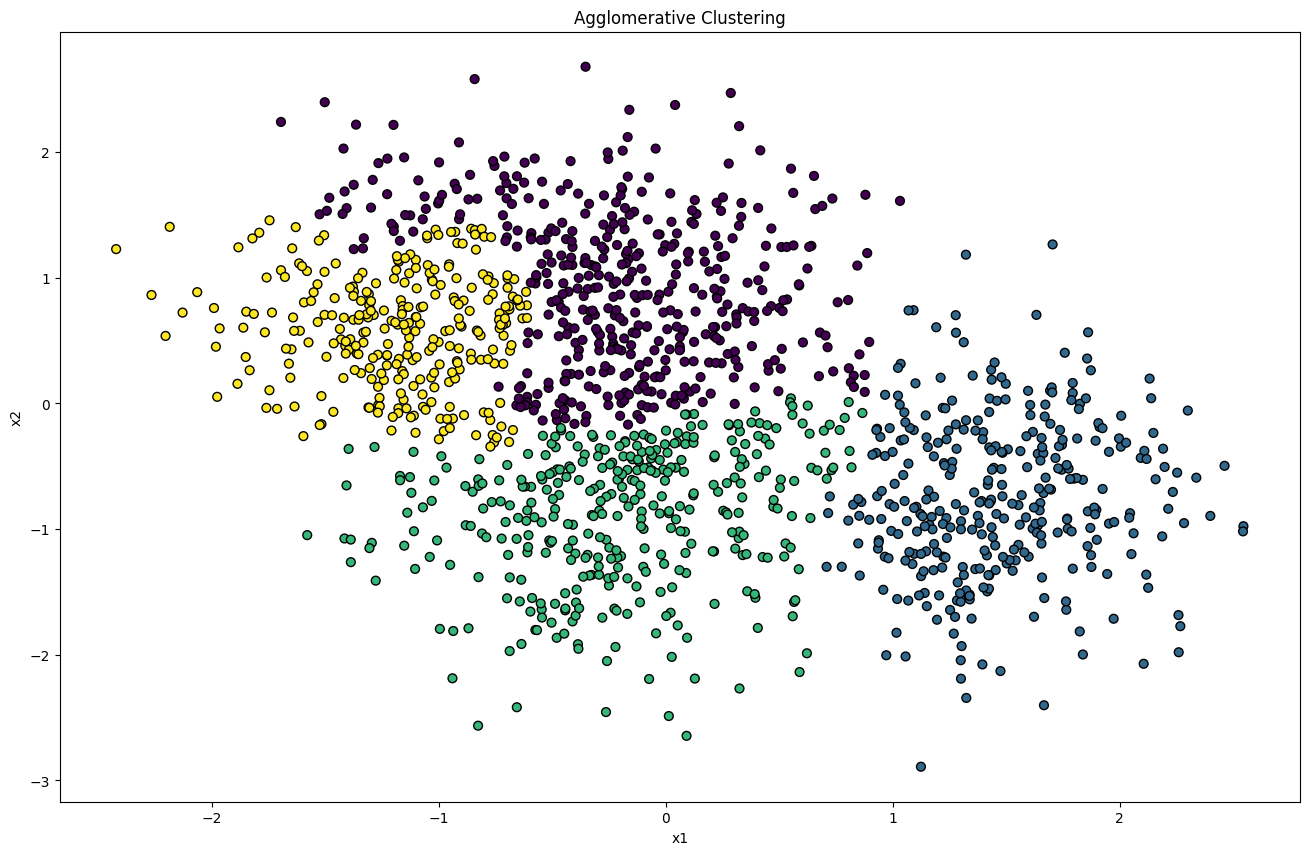

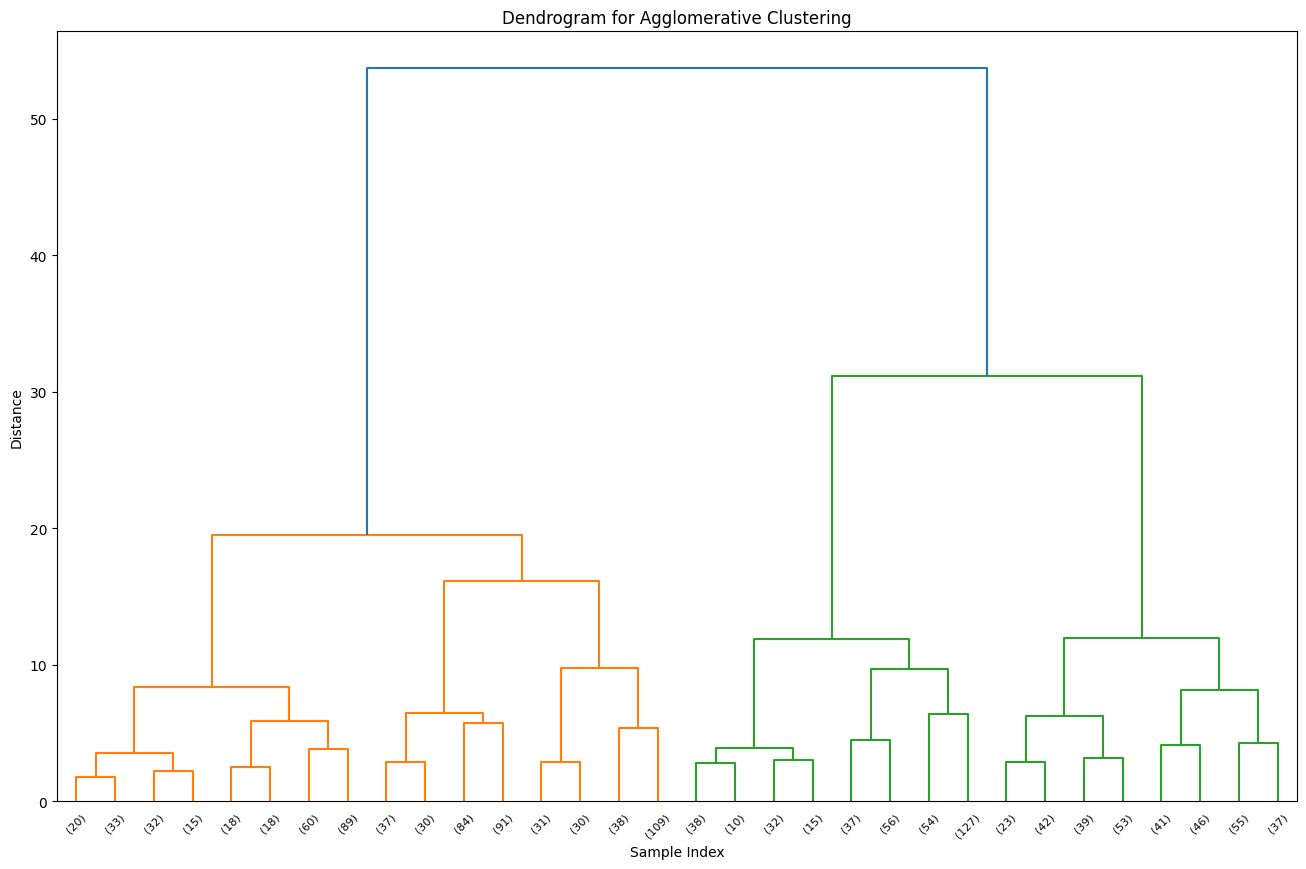

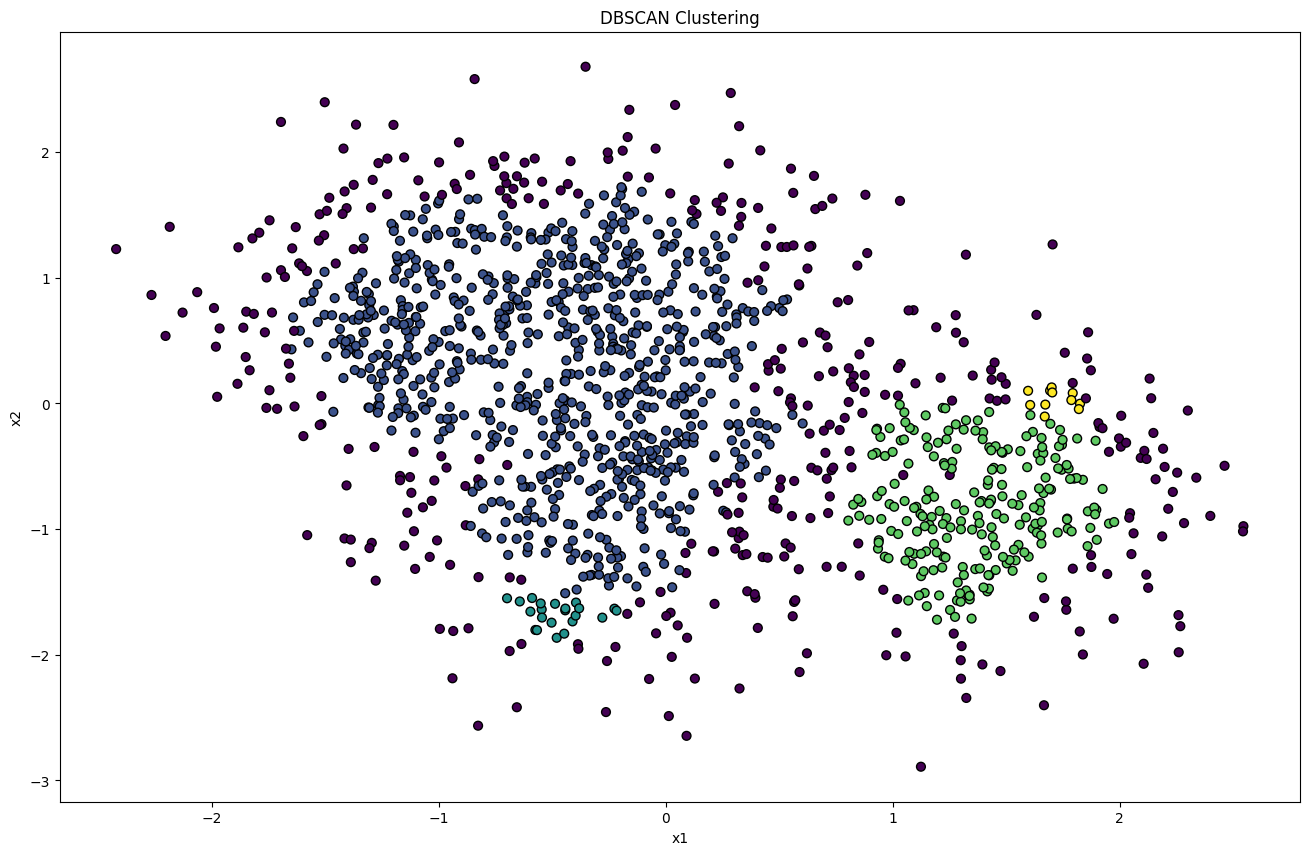

Best DBSCAN parameters: eps=0.17040201005025127, min_samples=13


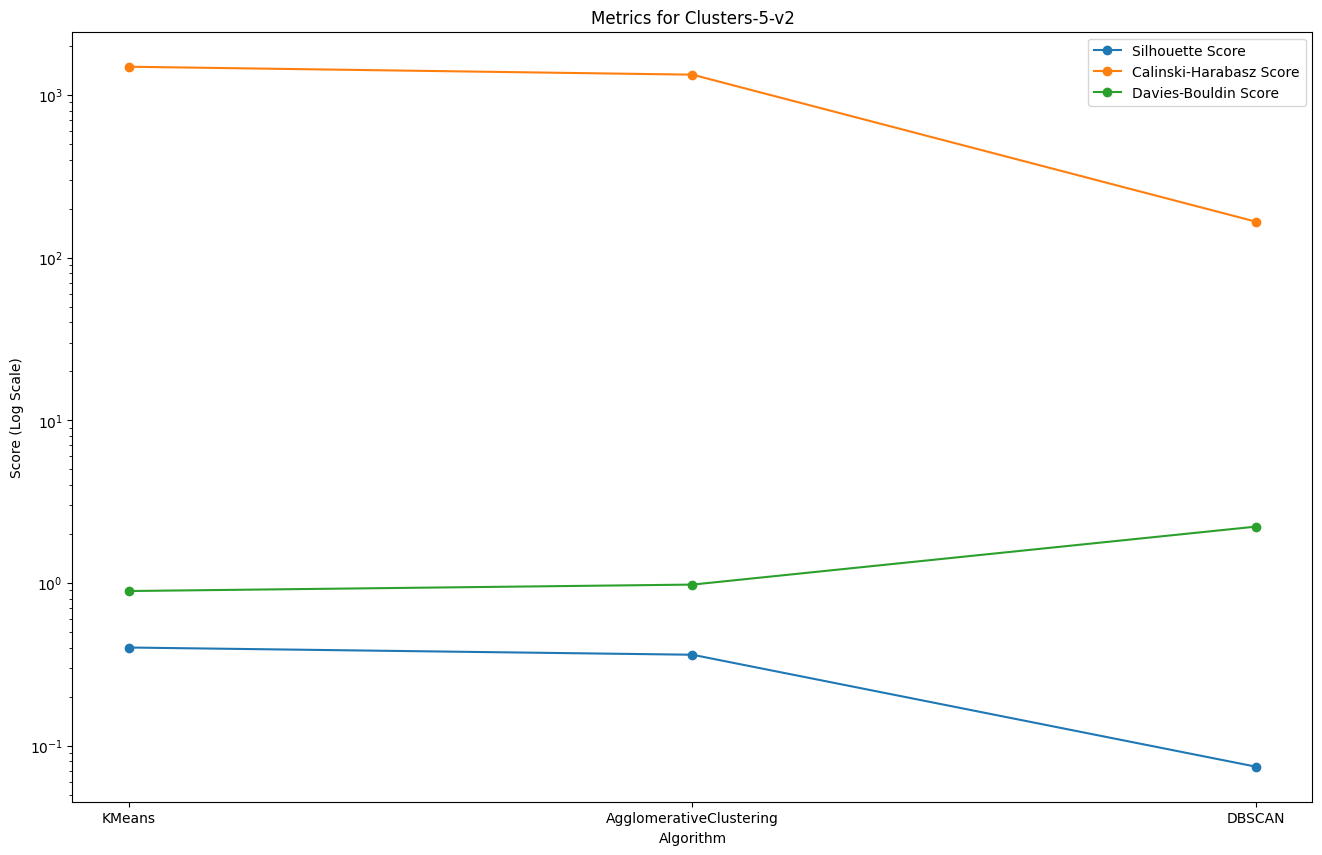

In [4]:
def plot_clusters(data, labels, title, name):
    plt.figure(figsize=(16, 10))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=40, edgecolors='black')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig(f'Images/{name}-{title}.png', dpi=400)
    plt.show()

def run_clustering(data, name):
    results = []
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    plot_clusters(data, kmeans_labels, 'K-Means Clustering', name)
    kmeans_metrics = [
        'KMeans',
        silhouette_score(data, kmeans_labels),
        calinski_harabasz_score(data, kmeans_labels),
        davies_bouldin_score(data, kmeans_labels)
    ]
    results.append(kmeans_metrics)

    # Agglomerative clustering
    agglomerative = AgglomerativeClustering(n_clusters=4)
    agglomerative_labels = agglomerative.fit_predict(data)
    plot_clusters(data, agglomerative_labels, 'Agglomerative Clustering', name)
    agglomerative_metrics = [
        'AgglomerativeClustering',
        silhouette_score(data, agglomerative_labels),
        calinski_harabasz_score(data, agglomerative_labels),
        davies_bouldin_score(data, agglomerative_labels)
    ]
    results.append(agglomerative_metrics)

    linkage_matrix = linkage(data, method='ward')

    # plot a dendrogram for the agglomerative clustering
    plt.figure(figsize=(16, 10))
    plt.title('Dendrogram for Agglomerative Clustering')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plot_dendrogram(linkage_matrix, truncate_mode='level', p=4)
    plt.savefig(f'Images/{name}-Agglomerative-Dendrogram.png', dpi=400)
    plt.show()

    # DBSCAN clustering with parameter tuning
    eps_values = np.linspace(0.01, 4, 200)  # 200 values between 0.01 and 4
    min_samples_values = range(4, 21)

    best_dbscan_labels = None
    best_dbscan_score = -np.inf
    best_eps, best_min_samples = None, None

    if name == 'Clusters-5-v0':
        eps = 0.3107537688442211
        min_samples = 9
    elif name == 'Clusters-5-v1':
        eps = 0.23055276381909548
        min_samples = 20
    elif name == 'Clusters-5-v2':
        eps = 0.17040201005025127
        min_samples = 13

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)
    best_dbscan_labels = dbscan_labels
    best_dbscan_score = silhouette_score(data, dbscan_labels)
    best_eps = eps
    best_min_samples = min_samples

    if best_dbscan_labels is not None:
        plot_clusters(data, best_dbscan_labels, 'DBSCAN Clustering', name)
        dbscan_metrics = [
            'DBSCAN',
            best_dbscan_score,
            calinski_harabasz_score(data, best_dbscan_labels),
            davies_bouldin_score(data, best_dbscan_labels)
        ]
        print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
    else:
        dbscan_metrics = ['DBSCAN', 'N/A', 'N/A', 'N/A']
        print("DBSCAN could not find exactly 4 clusters.")
    
    results.append(dbscan_metrics)

    # Save metrics to CSV
    result_df = pd.DataFrame(results, columns=['Algorithm', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
    result_df.to_csv(f'Metrics/{name}-metrics.csv', index=False)

    # plot the metrics for each dataset and each clustering algorithm
    plt.figure(figsize=(16, 10))
    plt.plot(result_df['Algorithm'], result_df['Silhouette Score'], marker='o', label='Silhouette Score')
    plt.plot(result_df['Algorithm'], result_df['Calinski-Harabasz Score'], marker='o', label='Calinski-Harabasz Score')
    plt.plot(result_df['Algorithm'], result_df['Davies-Bouldin Score'], marker='o', label='Davies-Bouldin Score')
    plt.title(f'Metrics for {name}')
    plt.yscale('log')
    plt.ylabel('Score (Log Scale)')
    plt.xlabel('Algorithm')
    plt.legend()
    plt.savefig(f'Metrics/{name}-metrics.png', dpi=400)
    plt.show()

    return results

# Example use case:
# Assuming 'dataset' is a dictionary where the key is the dataset name and the value is the data
for name, data in dataset.items():
    scaled_data = scalers[name]
    clustering_results = run_clustering(scaled_data, name)
